In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable

In [21]:
# functions for plotting predictions and losses of the two types of models

def plot_predictions(x_grid, y_predict_vanilla, y_output_modified, y_exact, n_outputs, loss_pointwise=False):

    plt.figure(figsize=(16, 8))

    for n in range(n_outputs):

        plt.subplot(1, n_outputs, n+1)

        plt.plot(x_grid, y_predict_vanilla[:, n], label='Vanilla')
        plt.plot(x_grid, y_output_modified[:, n], label='Modified')
        plt.plot(x_grid, y_exact[:, n], label='Exact')
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Predictions of the Models')
        plt.legend()

    if loss_pointwise:

        plt.figure(figsize=(16, 8))

        for n in range(n_outputs):

            plt.subplot(1, n_outputs, n+1)

            loss_vanilla = (y_predict_vanilla[:, n] - y_exact[:, n])**2
            loss_modified = (y_output_modified[:, n] - y_exact[:, n])**2
            plt.plot(x_grid, loss_vanilla, label='Vanilla')
            plt.plot(x_grid, loss_modified, label='Modified')
            plt.grid()
            plt.xlabel('x')
            plt.ylabel('Loss')
            plt.title('Losses of the Models')
            plt.legend()

def plot_loss(train_loss_vanilla, train_loss_modified, plot_range):

    plt.figure(figsize=(16, 8))

    plt.plot(np.arange(plot_range[0], plot_range[1]), train_loss_vanilla[plot_range[0]:plot_range[1]], label='Losses for Vanilla Model during Training')
    plt.plot(np.arange(plot_range[0], plot_range[1]), train_loss_modified[plot_range[0]:plot_range[1]], label='Losses for Modified Model during Training')
    plt.grid()
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Losses during Training')
    plt.legend()

def training_vanilla(loss_function, x_range, n_outputs, BC1, BC2, num_epochs, x_grid, batch_size, gamma, lr, lr_decay_steps, lr_decay_rate):

    # initialise the model

    model = NN_ODE(H, n_outputs)

    optimiser = opt.Adam(model.parameters(), lr=lr)
    scheduler = opt.lr_scheduler.StepLR(optimiser, step_size=lr_decay_steps, gamma=lr_decay_rate)

    model.train()

    n_training = len(x_grid)
    train_loss_vanilla = []

    for epoch in range(num_epochs):

        # loss in each epoch
        train_loss_vanilla_epoch = []

        # shuffle the data
        index = torch.randperm(len(x_grid))
        x_train = x_grid[index]

        for i in range(0, len(x_train), batch_size):

            # mini-batch
            x_train_batch = x_train[i:i+batch_size, :]
            x_train_batch = Variable(x_train_batch, requires_grad=True)

            loss = loss_function(x_range, BC1, BC2, x_train_batch, model, gamma)

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

            train_loss_vanilla_epoch.append(loss)

        train_loss_vanilla.append(sum(train_loss_vanilla_epoch)/(n_training/batch_size))

        scheduler.step()

        if ( epoch%lr_decay_steps==(lr_decay_steps-1) ):

            print('Epochs %i/%i. Loss: %.8f.' %(epoch+1, num_epochs, train_loss_vanilla[-1]))

    return train_loss_vanilla, model

def training_modified(loss_function, prediction2output, x_range, n_outputs, BC1, BC2, num_epochs, x_grid, batch_size, lr, lr_decay_steps, lr_decay_rate):

    # initialise the model

    model = NN_ODE(H, n_outputs)

    optimiser = opt.Adam(model.parameters(), lr=lr)
    scheduler = opt.lr_scheduler.StepLR(optimiser, step_size=lr_decay_steps, gamma=lr_decay_rate)

    model.train()

    n_training = len(x_grid)
    train_loss_modified = []

    for epoch in range(num_epochs):

        train_loss_modified_epoch = []

        index = torch.randperm(len(x_grid))
        x_train = x_grid[index]

        for i in range(0, len(x_train), batch_size):

            x_train_batch = x_train[i:i+batch_size, :]
            x_train_batch = Variable(x_train_batch, requires_grad=True)

            loss = loss_function(x_range, BC1, BC2, prediction2output, x_train_batch, model)

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

            train_loss_modified_epoch.append(loss)

        train_loss_modified.append(sum(train_loss_modified_epoch)/(n_training/batch_size))

        scheduler.step()

        if ( epoch%lr_decay_steps==(lr_decay_steps-1) ):

            print('Epochs %i/%i. Loss: %.8f.' %(epoch+1, num_epochs, train_loss_modified[-1]))

    return train_loss_modified, model

In [3]:
# define the class for the NN model, with 2 hidden layers

class NN_ODE(nn.Module):

    def __init__(self, H, n_outputs):
        super(NN_ODE, self).__init__()
        self.activation = nn.Sigmoid()
        self.fc1 = nn.Linear(1, H, bias=False)
        self.fc2 = nn.Linear(H, H, bias=False)
        # self.fc3 = nn.Linear(H, H, bias=False)
        # self.fc4 = nn.Linear(H, H, bias=False)
        # self.fc5 = nn.Linear(H, H, bias=False)
        self.fc6 = nn.Linear(H, n_outputs, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        # x = self.activation(x)
        # x = self.fc3(x)
        # x = self.activation(x)
        # x = self.fc4(x)
        # x = self.activation(x)
        # x = self.fc5(x)
        x = self.activation(x)
        x = self.fc6(x)
        return x

In [4]:
print(NN_ODE.forward)

<function NN_ODE.forward at 0x7b38c7ba6200>


In [5]:
# want to solve y'' = -2 with y(0) = 1, y(1) = 1

# define common used parameters

# training points

n_training = [4, 8, 16, 32, 64, 128]
x_range = [0, 1]
x_grid_list = [torch.linspace(x_range[0], x_range[1], n, requires_grad=True).reshape(n, 1) for n in n_training]

# parameters for training

H = 128
batch_size = 2
num_epochs = 100
lr = 0.01
lr_decay_steps = int(num_epochs/10)
lr_decay_rate = 0.5

# boundary conditions

BC1 = 1
BC2 = 1

# number of equations in the system

n_outputs = 1

In [30]:
# vanilla model

# weight of terms about boundary condition in the loss function

gamma = 1

# define the loss function for vanilla model

def loss_vanilla(x_range, BC1, BC2, x, model, gamma):

    # compute the predicted y
    y_predict = model(x)
    y_predict_BC1 = model(x_range[0]*torch.ones((1, 1)))
    y_predict_BC2 = model(x_range[1]*torch.ones((1, 1)))
    # x_BC1 = x_range[0]*torch.ones((1, 1))
    # x_BC1 = Variable(x_BC1, requires_grad=True)
    # y_predict_BC1 = model(x_BC1)
    # x_BC2 = x_range[1]*torch.ones((1, 1))
    # x_BC2 = Variable(x_BC2, requires_grad=True)
    # y_predict_BC2 = model(x_BC2)

    # compute the gradient of y_hat w.r.t. x
    grad = torch.autograd.grad(y_predict, x, grad_outputs=torch.ones_like(y_predict), retain_graph=True, create_graph=True)[0]
    hess = torch.autograd.grad(grad, x, grad_outputs=torch.ones_like(grad), retain_graph=True, create_graph=True)[0]

    # grad_BC1 = torch.autograd.grad(y_predict_BC1, x_BC1, grad_outputs=torch.ones_like(y_predict_BC1), retain_graph=True, create_graph=True)[0]
    # grad_BC2 = torch.autograd.grad(y_predict_BC2, x_BC2, grad_outputs=torch.ones_like(y_predict_BC2), retain_graph=True, create_graph=True)[0]

    # loss = F**2 + gamma*(BC1**2 + BC2**2)
    loss = ((hess + 2)**2 + gamma*((y_predict_BC1 - BC1)**2 + (y_predict_BC2 - BC2)**2)).mean()

    return loss

models_vanilla = []

train_loss_vanilla, model_vanilla = training_vanilla(loss_vanilla, x_range, n_outputs, BC1, BC2,
                                    num_epochs, x_grid_list[4], batch_size, gamma, lr, lr_decay_steps, lr_decay_rate)

# for x_grid in x_grid_list:

#     train_loss_vanilla, model_vanilla = training_vanilla(loss_vanilla, x_range, n_outputs, BC1, BC2, num_epochs, x_grid, batch_size, gamma, lr, lr_decay_steps, lr_decay_rate)
#     models_vanilla.append(model_vanilla)

Epochs 10/100. Loss: 0.89018452.
Epochs 20/100. Loss: 0.24630553.
Epochs 30/100. Loss: 0.05853853.
Epochs 40/100. Loss: 0.03055697.
Epochs 50/100. Loss: 0.02262877.
Epochs 60/100. Loss: 0.01927717.
Epochs 70/100. Loss: 0.01778884.
Epochs 80/100. Loss: 0.01700743.
Epochs 90/100. Loss: 0.01661505.
Epochs 100/100. Loss: 0.01641374.


In [31]:
# define the transform and the loss function for modified model

def prediction2output(x_range, BC1, BC2, x, model):

    y_predict = model(x)
    # x_BC1 = x_range[0]*torch.ones((1, 1))
    # x_BC1 = Variable(x_BC1, requires_grad=True)
    # y_predict_BC1 = model(x_BC1)
    # grad_BC1 = torch.autograd.grad(y_predict_BC1, x_BC1, grad_outputs=torch.ones_like(y_predict_BC1),
                                   # retain_graph=True, create_graph=True)[0]
    # y_predict_BC2 = model(x_range[1]*torch.ones((1, 1)))

    # y_output = BC1 - BC2 - x - grad_BC1 + (1 - x)*(y_predict - y_predict_BC2)
    y_output = 1 + x*(1 - x)*y_predict

    return y_output

def loss_modified(x_range, BC1, BC2, prediction2output, x, model):

    y_output = prediction2output(x_range, BC1, BC2, x, model)

    # compute the gradient of y_bar w.r.t. x
    grad = torch.autograd.grad(y_output, x, grad_outputs=torch.ones_like(y_output), retain_graph=True, create_graph=True)[0]
    hess = torch.autograd.grad(grad, x, grad_outputs=torch.ones_like(grad), retain_graph=True, create_graph=True)[0]

    # loss = F**2
    loss = ((hess + 2)**2).mean()

    return loss

models_modified = []

train_loss_modified, model_modified = training_modified(loss_modified, prediction2output, x_range, n_outputs, BC1, BC2,
                                      num_epochs, x_grid_list[4], batch_size, lr, lr_decay_steps, lr_decay_rate)

# for x_grid in x_grid_list:

#     train_loss_modified, model_modified = training_modified(loss_modified, prediction2output, x_range, n_outputs, BC1, BC2, num_epochs, x_grid, batch_size, lr, lr_decay_steps, lr_decay_rate)

#     models_modified.append(model_modified)

Epochs 10/100. Loss: 0.00015958.
Epochs 20/100. Loss: 0.00000139.
Epochs 30/100. Loss: 0.00000128.
Epochs 40/100. Loss: 0.00000123.
Epochs 50/100. Loss: 0.00000122.
Epochs 60/100. Loss: 0.00000121.
Epochs 70/100. Loss: 0.00000121.
Epochs 80/100. Loss: 0.00000121.
Epochs 90/100. Loss: 0.00000121.
Epochs 100/100. Loss: 0.00000121.


In [8]:
# compute the predicted values for plots

x_grid = torch.linspace(x_range[0], x_range[1], n_training[4], requires_grad=True).reshape(n_training[4], 1)

y_predict_vanilla = model_vanilla(x_grid)
y_predict_modified = model_modified(x_grid)
y_output_modified = prediction2output(x_range, BC1, BC2, x_grid, model_modified)

# convert to numpy array for plotting
if ( type(x_grid).__module__!=np.__name__ ):
    x_grid = x_grid.detach().numpy()
if ( type(y_predict_vanilla).__module__!=np.__name__ ):
    y_predict_vanilla = y_predict_vanilla.detach().numpy()
if ( type(y_output_modified).__module__!=np.__name__ ):
    y_output_modified = y_output_modified.detach().numpy()

y_exact = 1 + x_grid*(1 - x_grid)

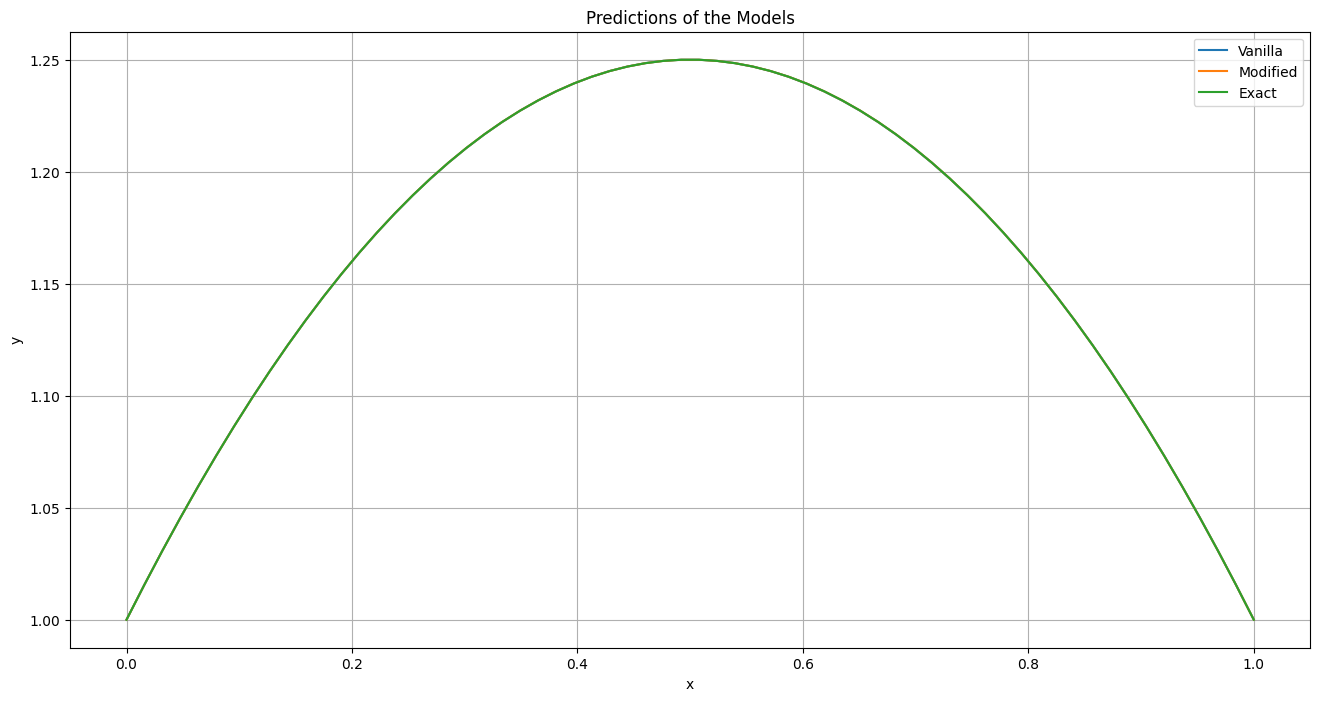

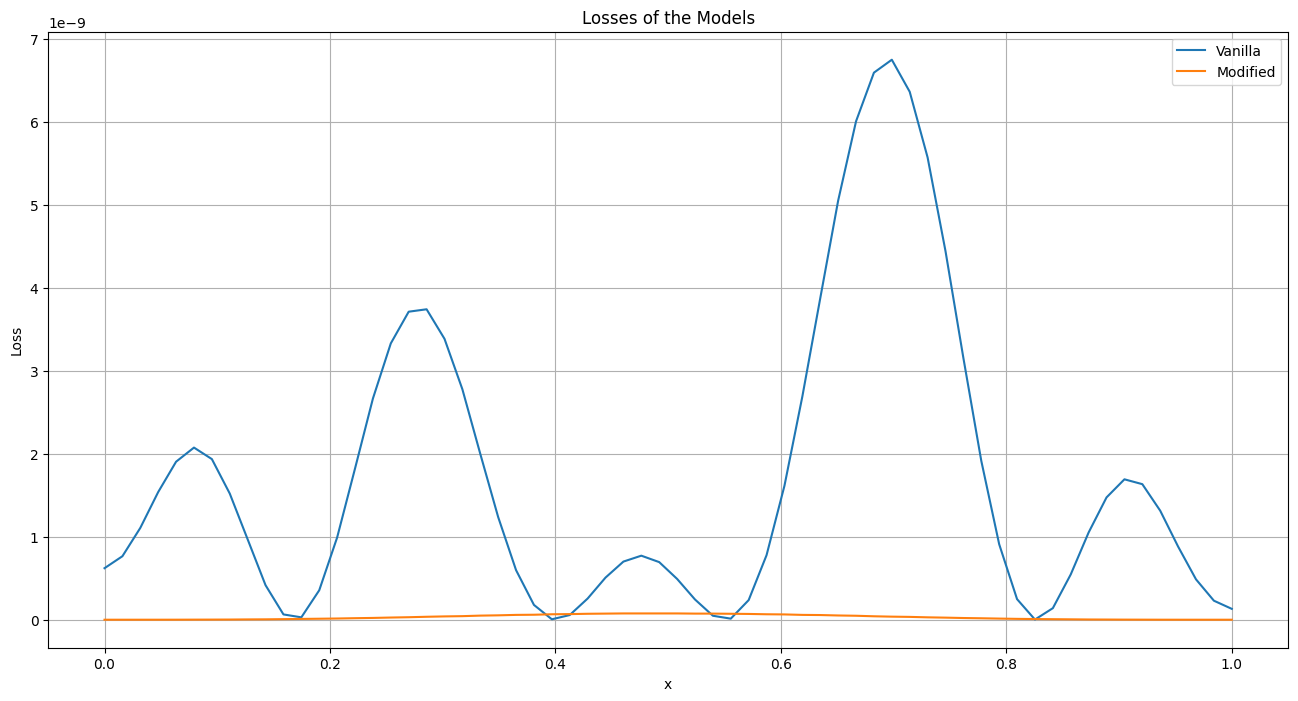

In [9]:
# plot the predictions and exact values

loss_pointwise = True
plot_predictions(x_grid, y_predict_vanilla, y_output_modified, y_exact, n_outputs, loss_pointwise=loss_pointwise)

In [10]:
# pre-process the list for losses for plotting

if ( type(train_loss_vanilla[0]).__module__!=np.__name__ ):
    for i in range(len(train_loss_vanilla)):
        train_loss_vanilla[i] = train_loss_vanilla[i].detach().numpy()
if ( type(train_loss_modified[0]).__module__!=np.__name__ ):
    for i in range(len(train_loss_modified)):
        train_loss_modified[i] = train_loss_modified[i].detach().numpy()

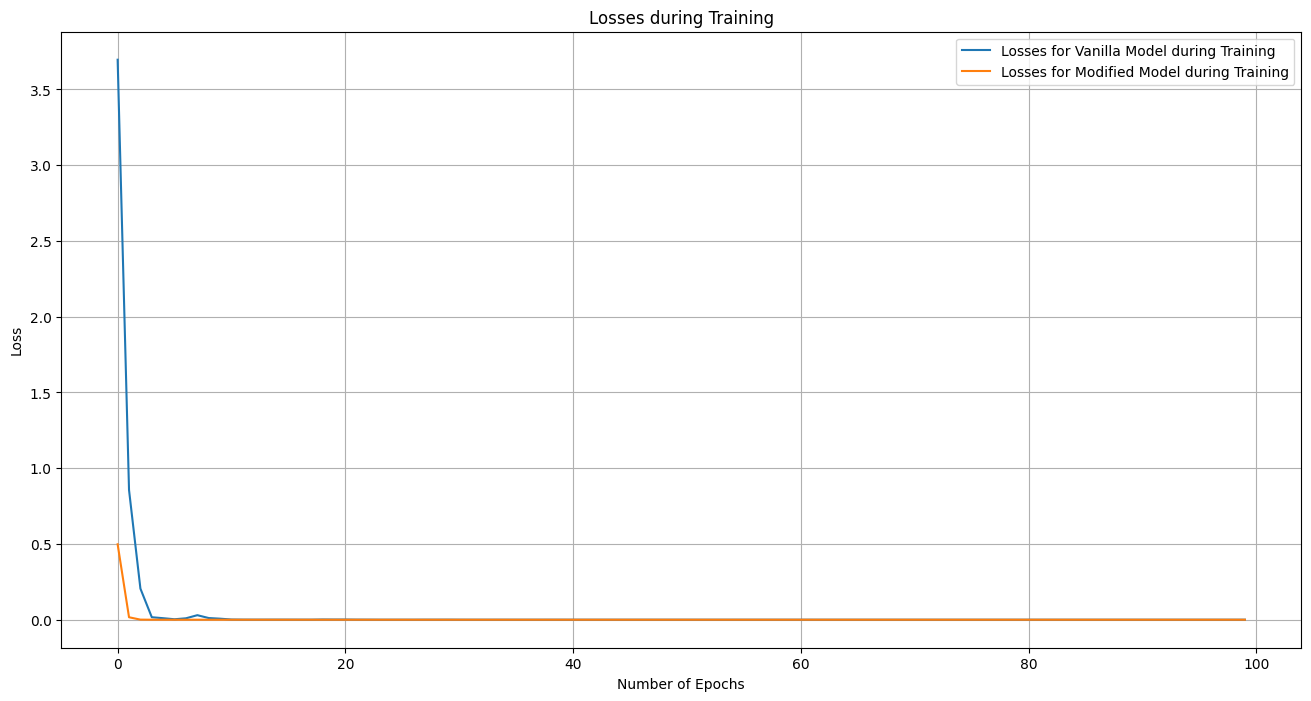

In [11]:
# plot the losses

plot_range = [0, 100]
plot_loss(train_loss_vanilla, train_loss_modified, plot_range)

In [ ]:
# this plots the loss as function of the number of training points
# we need to comment the for loops above out to use this

loss_vanilla_list = []
loss_modified_list = []

for i in range(len(x_grid_list)):

    x_grid = x_grid_list[i]
    model_vanilla = models_vanilla[i]
    model_modified = models_modified[i]
    y_predict_vanilla = model_vanilla(x_grid)
    y_predict_modified = model_modified(x_grid)
    y_output_modified = prediction2output(x_range, BC1, BC2, x_grid, model_modified)

    if ( type(x_grid).__module__!=np.__name__ ):
        x_grid = x_grid.detach().numpy()
    if ( type(y_predict_vanilla).__module__!=np.__name__ ):
        y_predict_vanilla = y_predict_vanilla.detach().numpy()
    if ( type(y_output_modified).__module__!=np.__name__ ):
        y_output_modified = y_output_modified.detach().numpy()

    y_exact = 1 + x_grid*(1 - x_grid)

    loss_vanilla_list.append(((y_predict_vanilla - y_exact)**2).mean())
    loss_modified_list.append(((y_output_modified - y_exact)**2).mean())

plt.figure(figsize=(16, 8))

plt.semilogy(n_training, loss_vanilla_list, label='Losses for Vanilla Models')
plt.semilogy(n_training, loss_modified_list, label='Losses for Modified Models')
plt.xlabel('Number of Training Points')
plt.ylabel('Loss')
plt.grid()
plt.title('Loss v.s. Number of Training Points')
plt.legend()

In [13]:
# Now working with system of equations
#  -u'' + xu - v = 2 + x
#  -v'' + v = 6x - 2 + x^2 (1 - x)

# define common used parameters

# training points

n_training = 128
x_range = [0, 1]
x_grid = torch.linspace(x_range[0], x_range[1], n_training, requires_grad=True).reshape(n_training, 1)

# parameters for training

H = 64
batch_size = 16
num_epochs = 100
lr = 0.01
lr_decay_steps = int(num_epochs/10)
lr_decay_rate = 0.5

# boundary conditions

BCl_u = 1
BCl_v = 0
BCr_u = 1
BCr_v = 0

# number of equations in the system

n_outputs = 2

In [14]:
# Redefining the training functions to work with a system of eqns

def training_vanilla(loss_function, x_range, n_outputs, BCl_u, BCl_v, BCr_u, BCr_v, num_epochs, x_grid, batch_size, gamma, lr, lr_decay_steps, lr_decay_rate):

    # initialise the model

    model = NN_ODE(H, n_outputs)

    optimiser = opt.Adam(model.parameters(), lr=lr)
    scheduler = opt.lr_scheduler.StepLR(optimiser, step_size=lr_decay_steps, gamma=lr_decay_rate)

    model.train()

    n_training = len(x_grid)
    train_loss_vanilla = []

    for epoch in range(num_epochs):

        # loss in each epoch
        train_loss_vanilla_epoch = []

        # shuffle the data
        index = torch.randperm(len(x_grid))
        x_train = x_grid[index]

        for i in range(0, len(x_train), batch_size):

            # mini-batch
            x_train_batch = x_train[i:i+batch_size, :]
            x_train_batch = Variable(x_train_batch, requires_grad=True)

            loss = loss_function(x_range, BCl_u, BCl_v, BCr_u, BCr_v, x_train_batch, model, gamma)

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

            train_loss_vanilla_epoch.append(loss)

        train_loss_vanilla.append(sum(train_loss_vanilla_epoch)/(n_training/batch_size))

        scheduler.step()

        if ( epoch%lr_decay_steps==(lr_decay_steps-1) ):

            print('Epochs %i/%i. Loss: %.8f.' %(epoch+1, num_epochs, train_loss_vanilla[-1]))

    return train_loss_vanilla, model



def training_modified(loss_function, prediction2output, x_range, n_outputs, BCl_u, BCl_v, BCr_u, BCr_v, num_epochs, x_grid, batch_size, lr, lr_decay_steps, lr_decay_rate):

    # initialise the model

    model = NN_ODE(H, n_outputs)

    optimiser = opt.Adam(model.parameters(), lr=lr)
    scheduler = opt.lr_scheduler.StepLR(optimiser, step_size=lr_decay_steps, gamma=lr_decay_rate)

    model.train()

    n_training = len(x_grid)
    train_loss_modified = []

    for epoch in range(num_epochs):

        train_loss_modified_epoch = []

        index = torch.randperm(len(x_grid))
        x_train = x_grid[index]

        for i in range(0, len(x_train), batch_size):

            x_train_batch = x_train[i:i+batch_size, :]
            x_train_batch = Variable(x_train_batch, requires_grad=True)

            loss = loss_function(x_range, BCl_u, BCl_v, BCr_u, BCr_v, prediction2output, x_train_batch, model)

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

            train_loss_modified_epoch.append(loss)

        train_loss_modified.append(sum(train_loss_modified_epoch)/(n_training/batch_size))

        scheduler.step()

        if ( epoch%lr_decay_steps==(lr_decay_steps-1) ):

            print('Epochs %i/%i. Loss: %.8f.' %(epoch+1, num_epochs, train_loss_modified[-1]))

    return train_loss_modified, model

In [15]:
# vanilla model

# weight of terms about boundary condition in the loss function

gamma = 1

# define the loss function for vanilla model

def loss_vanilla(x_range, BCl_u, BCl_v, BCr_u, BCr_v, x, model, gamma):

    # compute the predicted y
    y_predict = model(x)
    y_predict_BC1 = model(x_range[0]*torch.ones((1, 1)))
    y_predict_BC2 = model(x_range[1]*torch.ones((1, 1)))
    # x_BC1 = x_range[0]*torch.ones((1, 1))
    # x_BC1 = Variable(x_BC1, requires_grad=True)
    # y_predict_BC1 = model(x_BC1)
    # x_BC2 = x_range[1]*torch.ones((1, 1))
    # x_BC2 = Variable(x_BC2, requires_grad=True)
    # y_predict_BC2 = model(x_BC2)

    # compute the gradient of y_hat w.r.t. x
    grad_1 = torch.autograd.grad(y_predict[:, 0], x, grad_outputs=torch.ones_like(y_predict[:, 0]), retain_graph=True, create_graph=True)[0]
    hess_1 = torch.autograd.grad(grad_1, x, grad_outputs=torch.ones_like(grad_1), retain_graph=True, create_graph=True)[0]
    grad_2 = torch.autograd.grad(y_predict[:, 1], x, grad_outputs=torch.ones_like(y_predict[:, 1]), retain_graph=True, create_graph=True)[0]
    hess_2 = torch.autograd.grad(grad_2, x, grad_outputs=torch.ones_like(grad_2), retain_graph=True, create_graph=True)[0]

    # grad_BC1 = torch.autograd.grad(y_predict_BC1, x_BC1, grad_outputs=torch.ones_like(y_predict_BC1), retain_graph=True, create_graph=True)[0]
    # grad_BC2 = torch.autograd.grad(y_predict_BC2, x_BC2, grad_outputs=torch.ones_like(y_predict_BC2), retain_graph=True, create_graph=True)[0]

    # loss = F**2 + gamma*(BC1**2 + BC2**2)
    loss = ((-hess_1 + x*y_predict[:, 0] - y_predict[:, 1] - 2 - x)**2 + (-hess_2 + y_predict[:, 1] - 6*x + 2 - x**2*(1 - x))**2
            + gamma*((y_predict_BC1[:, 0] - BCl_u)**2 + (y_predict_BC1[:, 1] - BCl_v)**2
                     + (y_predict_BC2[:, 0] - BCr_u)**2 + (y_predict_BC2[:, 1] - BCr_v)**2)).mean()

    return loss

models_vanilla = []

_, model_vanilla = training_vanilla(loss_vanilla, x_range, n_outputs, BCl_u, BCl_v, BCr_u, BCr_v,
                                    num_epochs, x_grid, batch_size, gamma, lr, lr_decay_steps, lr_decay_rate)

# for x_grid in x_grid_list:

    # train_loss_vanilla, model_vanilla = training_vanilla(loss_vanilla, x_range, n_outputs, BC1, BC2,
                                                         # num_epochs, x_grid, batch_size, gamma, lr_decay_steps, lr_decay_rate)
    # models_vanilla.append(model_vanilla)

Epochs 10/100. Loss: 1.93049860.
Epochs 20/100. Loss: 0.04542757.
Epochs 30/100. Loss: 0.02603260.
Epochs 40/100. Loss: 0.02061756.
Epochs 50/100. Loss: 0.01814199.
Epochs 60/100. Loss: 0.01700503.
Epochs 70/100. Loss: 0.01667498.
Epochs 80/100. Loss: 0.01659727.
Epochs 90/100. Loss: 0.01654766.
Epochs 100/100. Loss: 0.01578354.


In [16]:
# define the transform and the loss function for modified model

def prediction2output(x_range, BCl_u, BCl_v, BCr_u, BCr_v, x, model):

    y_predict = model(x)
    # x_BC1 = x_range[0]*torch.ones((1, 1))
    # x_BC1 = Variable(x_BC1, requires_grad=True)
    # y_predict_BC1 = model(x_BC1)
    # grad_BC1 = torch.autograd.grad(y_predict_BC1, x_BC1, grad_outputs=torch.ones_like(y_predict_BC1),
                                   # retain_graph=True, create_graph=True)[0]
    # y_predict_BC2 = model(x_range[1]*torch.ones((1, 1)))

    # y_output = BC1 - BC2 - x - grad_BC1 + (1 - x)*(y_predict - y_predict_BC2)
    y_output = torch.cat((1 + x*(1 - x)*y_predict[:, 0].reshape(len(y_predict[:, 0]), 1),
                          x*(1 - x)*y_predict[:, 1].reshape(len(y_predict[:, 1]), 1)), 1)

    return y_output

def loss_modified(x_range, BCl_u, BCl_v, BCr_u, BCr_v, prediction2output, x, model):

    y_output = prediction2output(x_range, BCl_u, BCl_v, BCr_u, BCr_v, x, model)

    # compute the gradient of y_bar w.r.t. x
    grad_1 = torch.autograd.grad(y_output[:, 0], x, grad_outputs=torch.ones_like(y_output[:, 0]), retain_graph=True, create_graph=True)[0]
    hess_1 = torch.autograd.grad(grad_1, x, grad_outputs=torch.ones_like(grad_1), retain_graph=True, create_graph=True)[0]
    grad_2 = torch.autograd.grad(y_output[:, 1], x, grad_outputs=torch.ones_like(y_output[:, 1]), retain_graph=True, create_graph=True)[0]
    hess_2 = torch.autograd.grad(grad_2, x, grad_outputs=torch.ones_like(grad_2), retain_graph=True, create_graph=True)[0]

    # loss = F**2
    loss = ((-hess_1 + x*y_output[:, 0] - y_output[:, 1] - 2 - x)**2 + (-hess_2 + y_output[:, 1] - 6*x + 2 - x**2*(1 - x))**2).mean()

    return loss

models_modified = []

_, model_modified = training_modified(loss_modified, prediction2output, x_range, n_outputs, BCl_u, BCl_v, BCr_u, BCr_v,
                                      num_epochs, x_grid, batch_size, lr, lr_decay_steps, lr_decay_rate)

# for x_grid in x_grid_list:

    # train_loss_modified, model_modified = training_modified(loss_modified, prediction2output, x_range, n_outputs, BC1, BC2,
                                                            # num_epochs, x_grid, batch_size, lr_decay_steps, lr_decay_rate)

    # models_modified.append(model_modified)

Epochs 10/100. Loss: 0.00815960.
Epochs 20/100. Loss: 0.00559791.
Epochs 30/100. Loss: 0.00567548.
Epochs 40/100. Loss: 0.00540291.
Epochs 50/100. Loss: 0.00528741.
Epochs 60/100. Loss: 0.00535954.
Epochs 70/100. Loss: 0.00547667.
Epochs 80/100. Loss: 0.00522505.
Epochs 90/100. Loss: 0.00535789.
Epochs 100/100. Loss: 0.00546441.


In [17]:
# compute the predicted values for plots

x_grid = torch.linspace(x_range[0], x_range[1], n_training, requires_grad=True).reshape(n_training, 1)

y_predict_vanilla = model_vanilla(x_grid)
y_predict_modified = model_modified(x_grid)
y_output_modified = prediction2output(x_range, BCl_u, BCl_v, BCr_u, BCr_v, x_grid, model_modified)

# convert to numpy array for plotting
if ( type(x_grid).__module__!=np.__name__ ):
    x_grid = x_grid.detach().numpy()
if ( type(y_predict_vanilla).__module__!=np.__name__ ):
    y_predict_vanilla = y_predict_vanilla.detach().numpy()
if ( type(y_output_modified).__module__!=np.__name__ ):
    y_output_modified = y_output_modified.detach().numpy()

y_exact = np.concatenate([1 + x_grid*(1 - x_grid), x_grid**2*(1-x_grid)], axis = 1)
y_exact.shape

(128, 2)

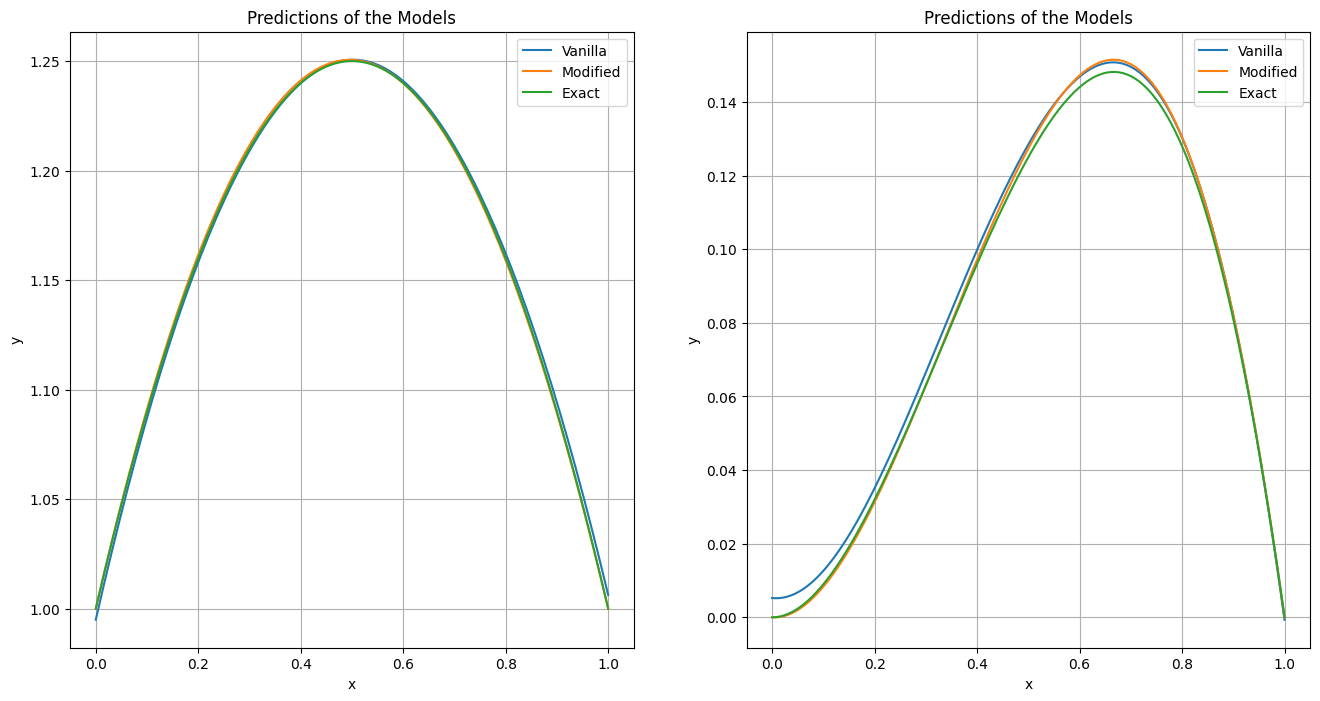

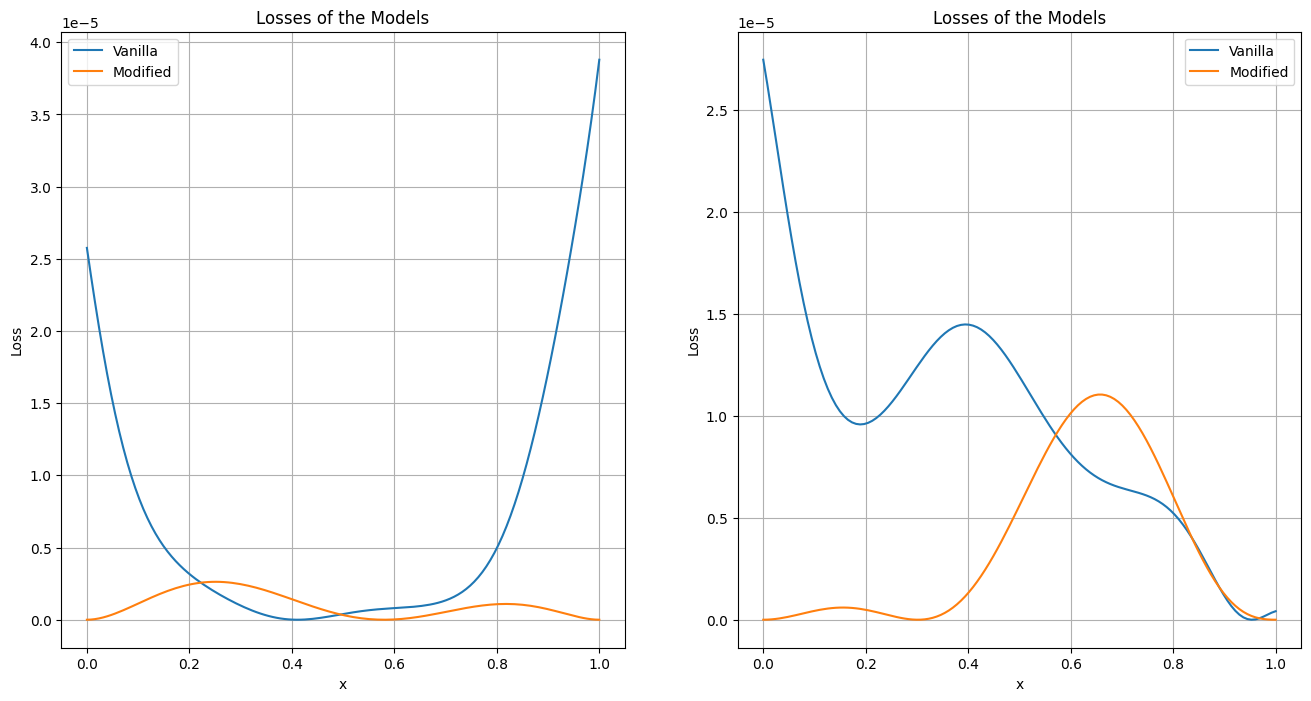

In [18]:
# plot the predictions and exact values

loss_pointwise = True
plot_predictions(x_grid, y_predict_vanilla, y_output_modified, y_exact, n_outputs, loss_pointwise=loss_pointwise)

In [19]:
# One dimensional model again. Make sure you run the first training functions before running
# solving y'' = 4*pi^2*sin(2*pi*x)

# define common used parameters

# training points

n_training = 64
x_range = [0, 1]
x_grid = torch.linspace(x_range[0], x_range[1], n_training, requires_grad=True).reshape(n_training, 1)

# parameters for training

H = 20
batch_size = 8
num_epochs = 100
lr = 0.01
lr_decay_steps = int(num_epochs/10)
lr_decay_rate = 0.5

# boundary conditions

BC1 = 0
BC2 = 0

# number of equations in the system

n_outputs = 1

In [22]:
# vanilla model

# weight of terms about boundary condition in the loss function

gamma = 1

# define the loss function for vanilla model

def loss_vanilla(x_range, BC1, BC2, x, model, gamma):

    # compute the predicted y
    y_predict = model(x)
    y_predict_BC1 = model(x_range[0]*torch.ones((1, 1)))
    y_predict_BC2 = model(x_range[1]*torch.ones((1, 1)))
    # x_BC1 = x_range[0]*torch.ones((1, 1))
    # x_BC1 = Variable(x_BC1, requires_grad=True)
    # y_predict_BC1 = model(x_BC1)
    # x_BC2 = x_range[1]*torch.ones((1, 1))
    # x_BC2 = Variable(x_BC2, requires_grad=True)
    # y_predict_BC2 = model(x_BC2)

    # compute the gradient of y_hat w.r.t. x
    grad = torch.autograd.grad(y_predict, x, grad_outputs=torch.ones_like(y_predict), retain_graph=True, create_graph=True)[0]
    hess = torch.autograd.grad(grad, x, grad_outputs=torch.ones_like(grad), retain_graph=True, create_graph=True)[0]

    # grad_BC1 = torch.autograd.grad(y_predict_BC1, x_BC1, grad_outputs=torch.ones_like(y_predict_BC1), retain_graph=True, create_graph=True)[0]
    # grad_BC2 = torch.autograd.grad(y_predict_BC2, x_BC2, grad_outputs=torch.ones_like(y_predict_BC2), retain_graph=True, create_graph=True)[0]

    # loss = F**2 + gamma*(BC1**2 + BC2**2)
    loss = ((hess + 4*torch.pi**2*torch.sin(2*torch.pi*x))**2 + gamma*((y_predict_BC1 - BC1)**2 + (y_predict_BC2 - BC2)**2)).mean()

    return loss

models_vanilla = []

_, model_vanilla = training_vanilla(loss_vanilla, x_range, n_outputs, BC1, BC2,
                                    num_epochs, x_grid, batch_size, gamma, lr, lr_decay_steps, lr_decay_rate)

# for x_grid in x_grid_list:

    # train_loss_vanilla, model_vanilla = training_vanilla(loss_vanilla, x_range, n_outputs, BC1, BC2,
                                                         # num_epochs, x_grid, batch_size, gamma, lr_decay_steps, lr_decay_rate)
    # models_vanilla.append(model_vanilla)

Epochs 10/100. Loss: 198.85527039.
Epochs 20/100. Loss: 92.08393860.
Epochs 30/100. Loss: 72.36225891.
Epochs 40/100. Loss: 67.54969025.
Epochs 50/100. Loss: 65.93630981.
Epochs 60/100. Loss: 65.26847839.
Epochs 70/100. Loss: 64.94779968.
Epochs 80/100. Loss: 64.79722595.
Epochs 90/100. Loss: 64.71998596.
Epochs 100/100. Loss: 64.68456268.


In [23]:
# define the transform and the loss function for modified model

def prediction2output(x_range, BC1, BC2, x, model):

    y_predict = model(x)
    # x_BC1 = x_range[0]*torch.ones((1, 1))
    # x_BC1 = Variable(x_BC1, requires_grad=True)
    # y_predict_BC1 = model(x_BC1)
    # grad_BC1 = torch.autograd.grad(y_predict_BC1, x_BC1, grad_outputs=torch.ones_like(y_predict_BC1),
                                   # retain_graph=True, create_graph=True)[0]
    # y_predict_BC2 = model(x_range[1]*torch.ones((1, 1)))

    # y_output = BC1 - BC2 - x - grad_BC1 + (1 - x)*(y_predict - y_predict_BC2)
    y_output = x*(1 - x)*y_predict

    return y_output

def loss_modified(x_range, BC1, BC2, prediction2output, x, model):

    y_output = prediction2output(x_range, BC1, BC2, x, model)

    # compute the gradient of y_bar w.r.t. x
    grad = torch.autograd.grad(y_output, x, grad_outputs=torch.ones_like(y_output), retain_graph=True, create_graph=True)[0]
    hess = torch.autograd.grad(grad, x, grad_outputs=torch.ones_like(grad), retain_graph=True, create_graph=True)[0]

    # loss = F**2
    loss = ((hess + 4*torch.pi**2*torch.sin(2*torch.pi*x))**2).mean()

    return loss

models_modified = []

_, model_modified = training_modified(loss_modified, prediction2output, x_range, n_outputs, BC1, BC2,
                                      num_epochs, x_grid, batch_size, 0.01, lr_decay_steps, lr_decay_rate)

# for x_grid in x_grid_list:

    # train_loss_modified, model_modified = training_modified(loss_modified, prediction2output, x_range, n_outputs, BC1, BC2,
                                                            # num_epochs, x_grid, batch_size, lr_decay_steps, lr_decay_rate)

    # models_modified.append(model_modified)

Epochs 10/100. Loss: 377.48321533.
Epochs 20/100. Loss: 113.15045166.
Epochs 30/100. Loss: 71.56150818.
Epochs 40/100. Loss: 60.27034760.
Epochs 50/100. Loss: 56.26406860.
Epochs 60/100. Loss: 54.35664749.
Epochs 70/100. Loss: 53.51949310.
Epochs 80/100. Loss: 53.08857727.
Epochs 90/100. Loss: 52.87244797.
Epochs 100/100. Loss: 52.76401520.


In [24]:
# compute the predicted values for plots

x_grid = torch.linspace(x_range[0], x_range[1], n_training, requires_grad=True).reshape(n_training, 1)

y_predict_vanilla = model_vanilla(x_grid)
y_output_modified = prediction2output(x_range, BC1, BC2, x_grid, model_modified)

# convert to numpy array for plotting
if ( type(x_grid).__module__!=np.__name__ ):
    x_grid = x_grid.detach().numpy()
if ( type(y_predict_vanilla).__module__!=np.__name__ ):
    y_predict_vanilla = y_predict_vanilla.detach().numpy()
if ( type(y_output_modified).__module__!=np.__name__ ):
    y_output_modified = y_output_modified.detach().numpy()

y_exact = np.sin(2*np.pi*x_grid)

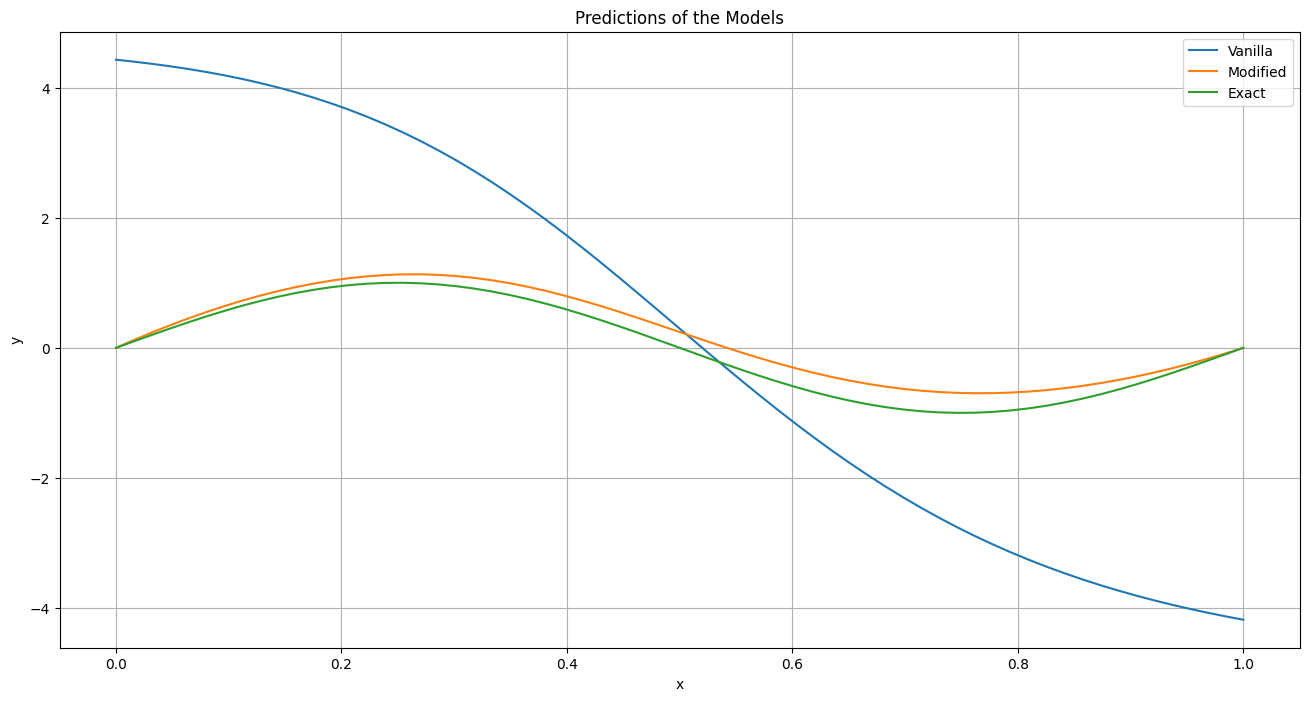

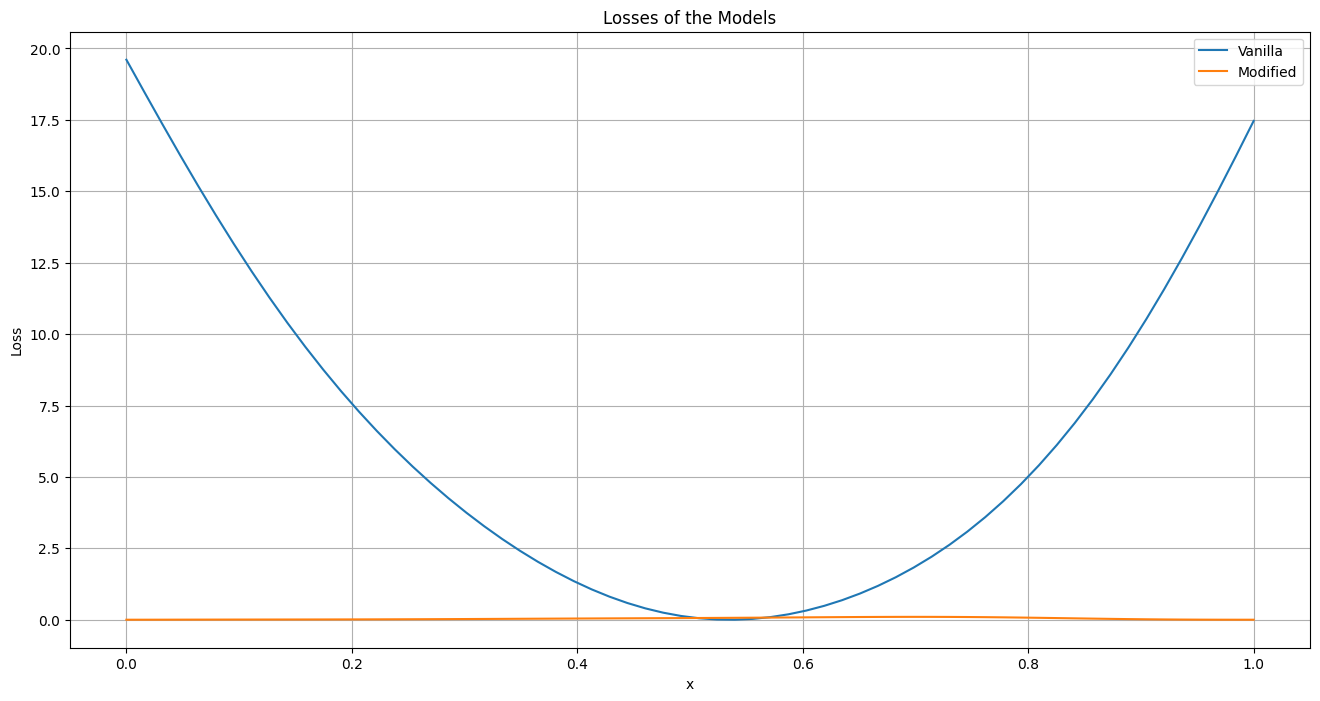

In [25]:
# plot the predictions and exact values

loss_pointwise = True
plot_predictions(x_grid, y_predict_vanilla, y_output_modified, y_exact, n_outputs, loss_pointwise=loss_pointwise)